# Lectura y Análisis

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import PchipInterpolator

from sklearn.neighbors import NearestNeighbors

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [69]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file + ".csv"
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        print(df_hourly.iloc[0])
        print(df_hourly.iloc[-1])
        
        dataframes[file] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [70]:
# Read the CSV files
directory = "data/"

#########
# Dates #
#########
start_date = "2024-03-01"
end_date = "2025-02-28"

location = "garachico"

grafcan = "grafcan_garachico"
openmeteo_arpege = "openmeteo_garachico_arpege"
openmeteo_icon = "openmeteo_garachico_icon"

data_files = [grafcan,
              openmeteo_arpege,
              openmeteo_icon]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing grafcan_garachico...


air_temperature          11.196628
atmospheric_pressure    916.643178
relative_humidity        86.514659
Name: 2024-03-01 00:00:00+00:00, dtype: float64
air_temperature           8.154772
atmospheric_pressure    914.368184
relative_humidity        87.944168
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_garachico_arpege...
air_temperature          12.7
atmospheric_pressure    915.3
relative_humidity        61.0
Name: 2024-03-01 00:00:00+00:00, dtype: float64
air_temperature          10.9
atmospheric_pressure    913.4
relative_humidity        70.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_garachico_icon...
air_temperature          11.4
atmospheric_pressure    916.8
relative_humidity        86.0
Name: 2024-03-01 00:00:00+00:00, dtype: float64
air_temperature           9.8
atmospheric_pressure    914.2
relative_humidity        85.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64


## Visualización

In [71]:
def plot_datasets_comparison(dataframes, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    print ("Plotting " + column)
    
    df_names = dataframes.keys()
    dfs = dataframes.values()
    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=df_names)
    
    # Ensure the indicated column exists in every dataset
    for name in df_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in df_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

Plotting air_temperature


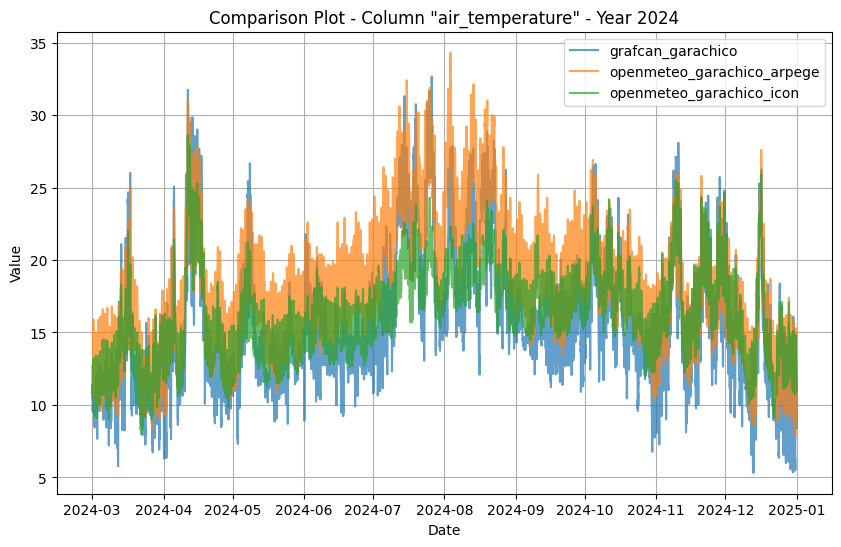

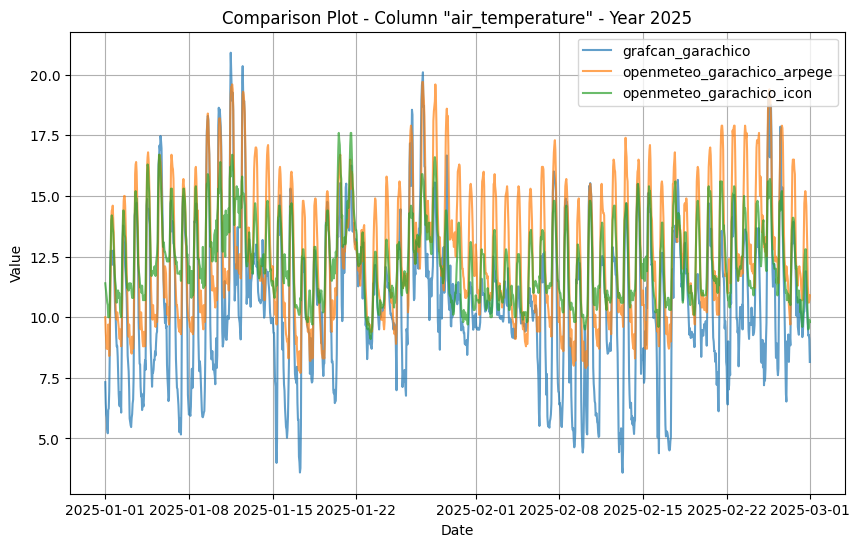

Plotting relative_humidity


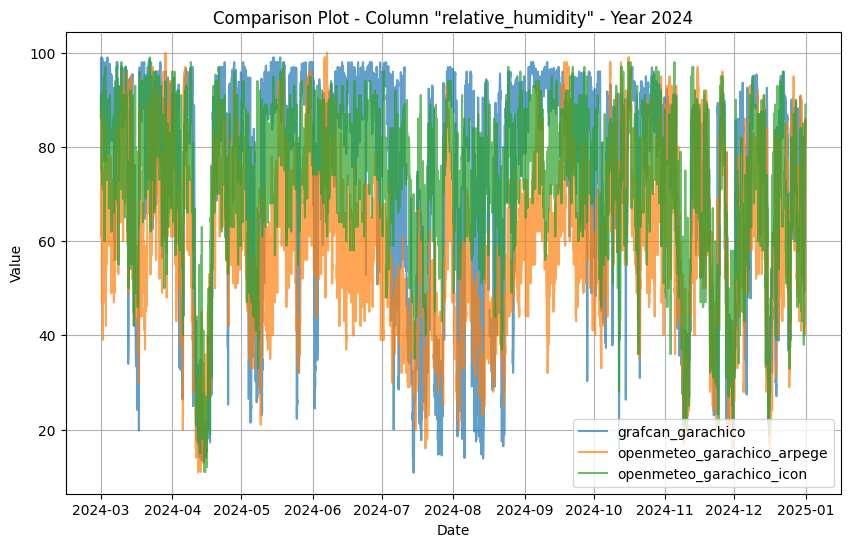

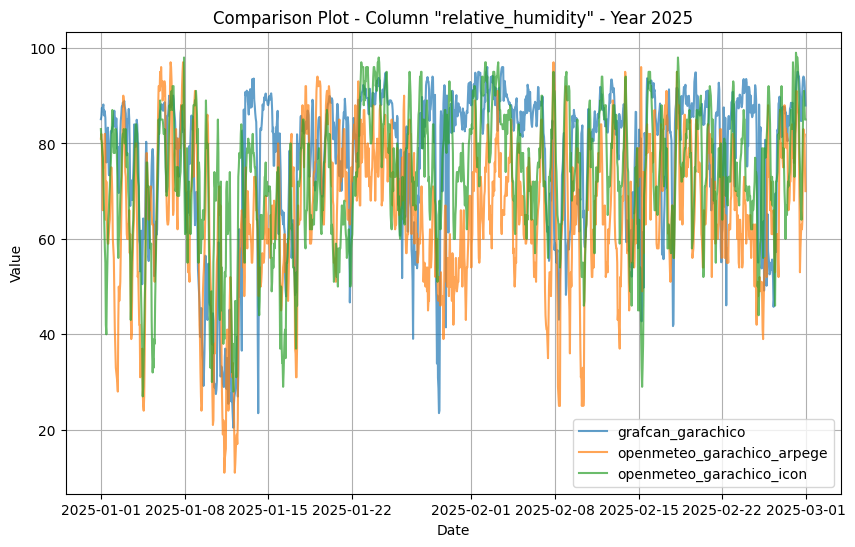

Plotting atmospheric_pressure


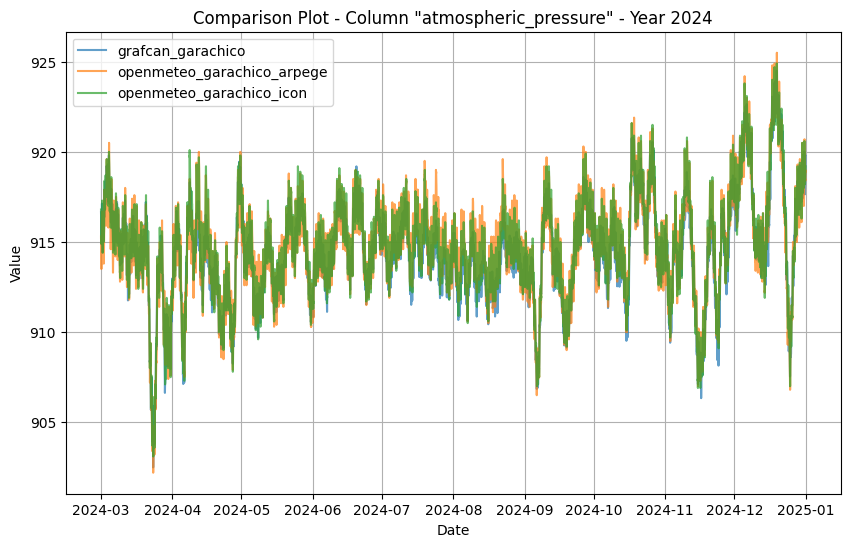

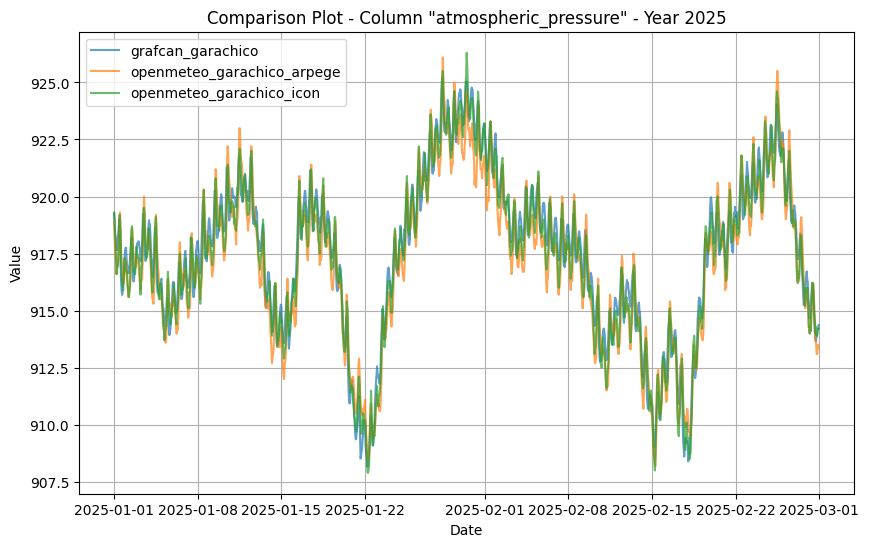

In [72]:
plot_datasets_comparison(dataframes, "air_temperature")
plot_datasets_comparison(dataframes, "relative_humidity")
plot_datasets_comparison(dataframes, "atmospheric_pressure")

## Horas faltantes

In [73]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in grafcan_garachico after resampling:
[Timestamp('2024-08-16 12:00:00+0000', tz='UTC'), Timestamp('2024-08-16 13:00:00+0000', tz='UTC'), Timestamp('2024-08-16 14:00:00+0000', tz='UTC'), Timestamp('2024-08-16 15:00:00+0000', tz='UTC'), Timestamp('2024-08-16 16:00:00+0000', tz='UTC')]
5
No missing hours in openmeteo_garachico_arpege after resampling.
No missing hours in openmeteo_garachico_icon after resampling.


### Manejo Horas faltantes

In [74]:
# Use pchip interpolation if gap is small (less or equal to threshold hours) else, use previous day data
def missing_interpolation(df, interpolation_threshold=4):
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex.")

    # Convert datetime index to numeric for interpolation
    numeric_index = df.index.astype('int64') // 10**9

    # Initialize artificial_value_flag column with zeros if not present
    if "artificial_value_flag" not in df.columns:
        df["artificial_value_flag"] = 0

    for col in df.columns:
        if col == "artificial_value_flag":
            continue

        series = df[col].copy()
        is_nan = series.isna()
        nan_groups = (is_nan != is_nan.shift()).cumsum()
        nan_runs = is_nan.groupby(nan_groups).sum()
        nan_starts = is_nan.groupby(nan_groups).agg(lambda x: x.index[0])

        # Process each missing block
        for run_length, start_time in zip(nan_runs, nan_starts):
            if run_length == 0:
                continue

            end_time = start_time + pd.Timedelta(hours=run_length - 1)
            time_range = pd.date_range(start_time, end_time, freq="h")

            if run_length > interpolation_threshold:
                # Fill using previous day's same hours
                prev_day_range = time_range - pd.Timedelta(days=1)
                try:
                    fill_values = df.loc[prev_day_range, col].values
                    df.loc[time_range, col] = fill_values
                    df.loc[time_range, "artificial_value_flag"] = 1
                except KeyError:
                    print(f"Previous day data not available to fill gap starting {start_time}")
            else:
                # Will interpolate these later
                continue

        # Interpolate remaining missing values (<= threshold hours)
        remaining_nan = df[col].isna()
        valid_mask = ~remaining_nan

        if valid_mask.sum() >= 2:
            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)
            df.loc[remaining_nan, col] = interpolated_values[remaining_nan]
            df.loc[remaining_nan, "artificial_value_flag"] = 1
        else:
            print(f"Not enough data points to interpolate column '{col}'.")

    return df

In [75]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    missing_interpolation(df_hourly)

## Comparativa datasets openmeteo

In [76]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1].drop(columns=["artificial_value_flag"])
    df2 = dataframes[file2].drop(columns=["artificial_value_flag"])
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [77]:
datasets_similarity(openmeteo_icon, grafcan)

Similarity Metrics for openmeteo_garachico_icon vs grafcan_garachico
  air_temperature:
    Pearson: 0.8799
    Spearman: 0.9060
    Kendall: 0.7315
    MSE: 6.6381
    Euclidean Distance: 241.1434
  atmospheric_pressure:
    Pearson: 0.9723
    Spearman: 0.9611
    Kendall: 0.8409
    MSE: 0.6695
    Euclidean Distance: 76.5848
  relative_humidity:
    Pearson: 0.6024
    Spearman: 0.5357
    Kendall: 0.3803
    MSE: 324.8695
    Euclidean Distance: 1686.9666


In [78]:
datasets_similarity(openmeteo_arpege, grafcan)

Similarity Metrics for openmeteo_garachico_arpege vs grafcan_garachico
  air_temperature:
    Pearson: 0.8916
    Spearman: 0.9003
    Kendall: 0.7263
    MSE: 10.7346
    Euclidean Distance: 306.6513
  atmospheric_pressure:
    Pearson: 0.9428
    Spearman: 0.9194
    Kendall: 0.7646
    MSE: 1.1867
    Euclidean Distance: 101.9592
  relative_humidity:
    Pearson: 0.5624
    Spearman: 0.4367
    Kendall: 0.2980
    MSE: 575.5470
    Euclidean Distance: 2245.3935


### Selección de datasets

In [79]:
new_df_openmeteo = "openmeteo_" + location
dataframes[new_df_openmeteo] = dataframes[openmeteo_icon].copy()

# Erase individual dataframes
del dataframes[openmeteo_icon]
del dataframes[openmeteo_arpege]

## Detección de outliers



### Análisis IQR

In [80]:
def detect_outliers_iqr(df, columns, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df[columns].columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing grafcan_garachico:


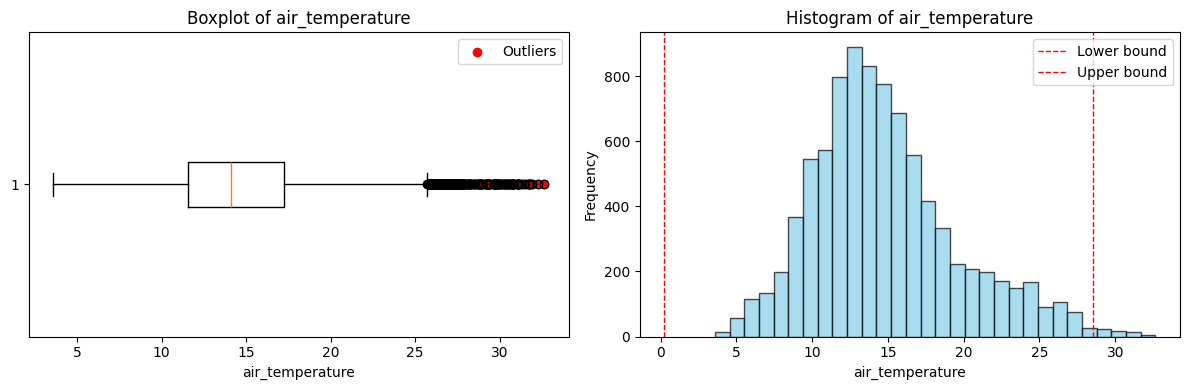

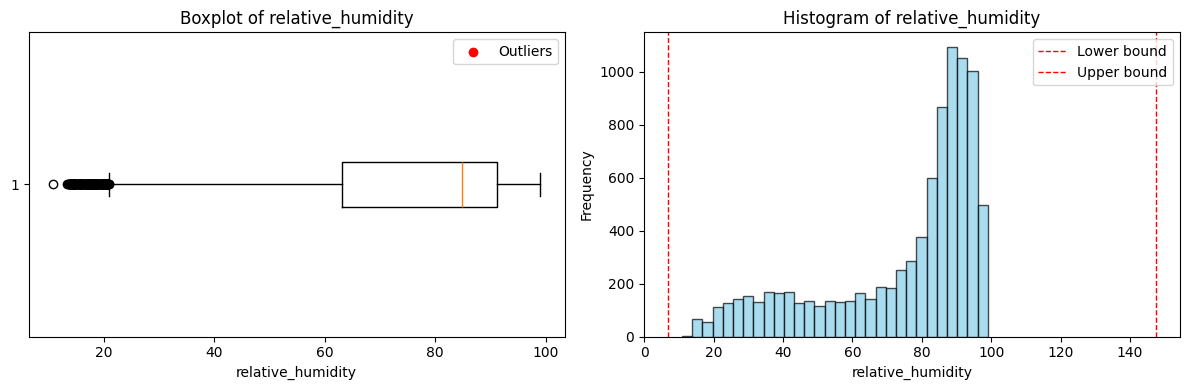

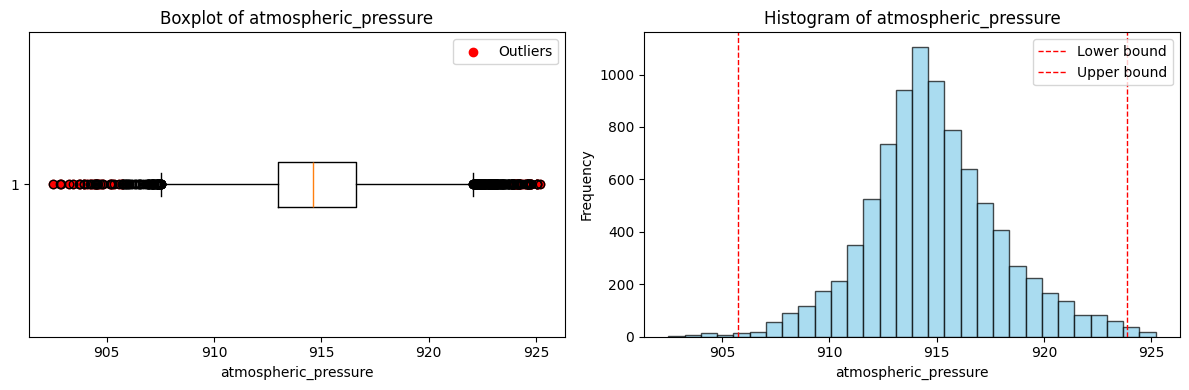

  air_temperature outlier row indices: [Timestamp('2024-04-11 11:00:00+0000', tz='UTC'), Timestamp('2024-04-11 12:00:00+0000', tz='UTC'), Timestamp('2024-04-11 13:00:00+0000', tz='UTC'), Timestamp('2024-04-11 14:00:00+0000', tz='UTC'), Timestamp('2024-04-11 15:00:00+0000', tz='UTC'), Timestamp('2024-04-11 16:00:00+0000', tz='UTC'), Timestamp('2024-04-11 17:00:00+0000', tz='UTC'), Timestamp('2024-04-11 18:00:00+0000', tz='UTC'), Timestamp('2024-04-12 11:00:00+0000', tz='UTC'), Timestamp('2024-04-12 12:00:00+0000', tz='UTC'), Timestamp('2024-04-12 13:00:00+0000', tz='UTC'), Timestamp('2024-04-12 14:00:00+0000', tz='UTC'), Timestamp('2024-04-12 15:00:00+0000', tz='UTC'), Timestamp('2024-04-12 16:00:00+0000', tz='UTC'), Timestamp('2024-04-13 10:00:00+0000', tz='UTC'), Timestamp('2024-04-13 11:00:00+0000', tz='UTC'), Timestamp('2024-04-13 12:00:00+0000', tz='UTC'), Timestamp('2024-04-13 13:00:00+0000', tz='UTC'), Timestamp('2024-04-13 14:00:00+0000', tz='UTC'), Timestamp('2024-04-13 15:00:0

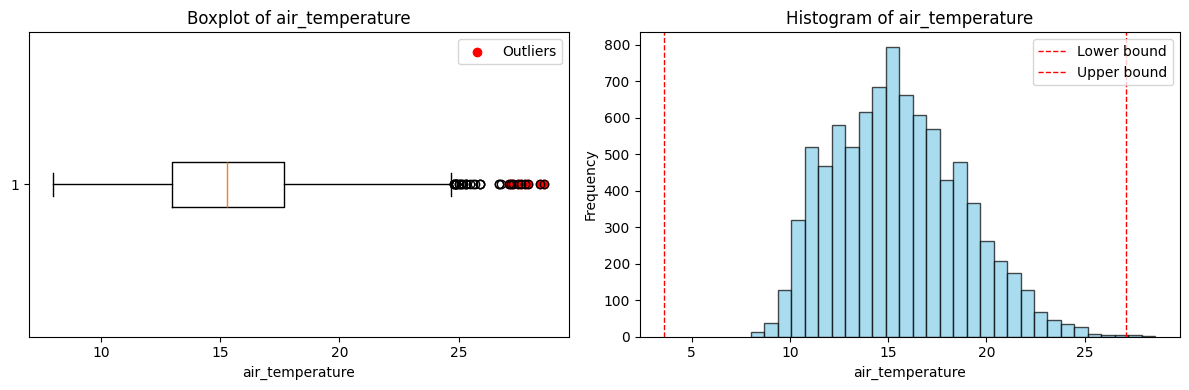

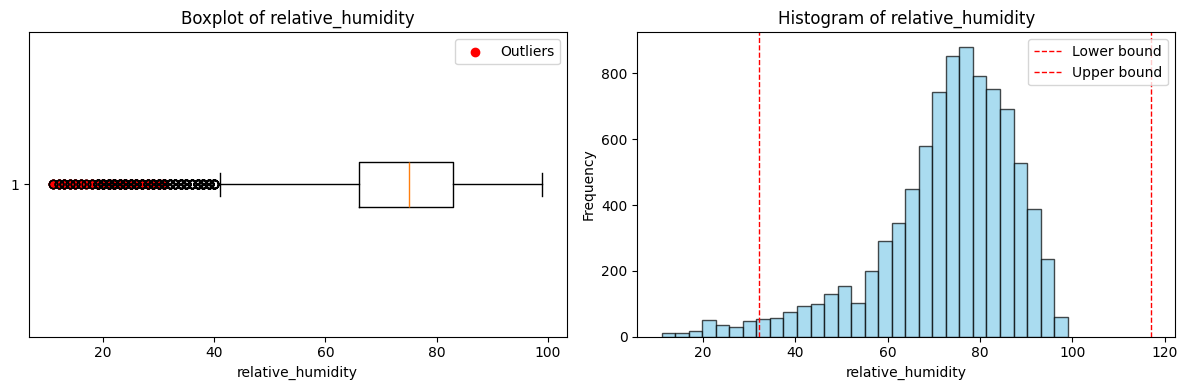

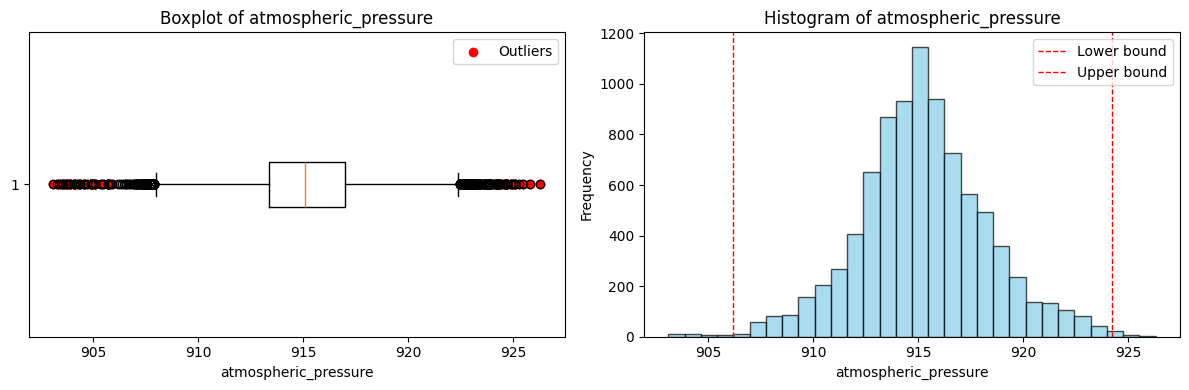

  air_temperature outlier row indices: [Timestamp('2024-04-11 11:00:00+0000', tz='UTC'), Timestamp('2024-04-11 12:00:00+0000', tz='UTC'), Timestamp('2024-04-11 13:00:00+0000', tz='UTC'), Timestamp('2024-04-11 14:00:00+0000', tz='UTC'), Timestamp('2024-04-11 15:00:00+0000', tz='UTC'), Timestamp('2024-04-12 10:00:00+0000', tz='UTC'), Timestamp('2024-04-12 11:00:00+0000', tz='UTC'), Timestamp('2024-04-12 12:00:00+0000', tz='UTC'), Timestamp('2024-04-12 13:00:00+0000', tz='UTC')]
  relative_humidity outlier row indices: [Timestamp('2024-04-11 03:00:00+0000', tz='UTC'), Timestamp('2024-04-11 04:00:00+0000', tz='UTC'), Timestamp('2024-04-11 05:00:00+0000', tz='UTC'), Timestamp('2024-04-11 06:00:00+0000', tz='UTC'), Timestamp('2024-04-11 07:00:00+0000', tz='UTC'), Timestamp('2024-04-11 08:00:00+0000', tz='UTC'), Timestamp('2024-04-11 09:00:00+0000', tz='UTC'), Timestamp('2024-04-11 10:00:00+0000', tz='UTC'), Timestamp('2024-04-11 11:00:00+0000', tz='UTC'), Timestamp('2024-04-11 12:00:00+0000'

In [81]:
threshold = 2
columns = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, columns, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Detected {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

### KNN

Processing grafcan_garachico for KNN outlier detection...
air_temperature


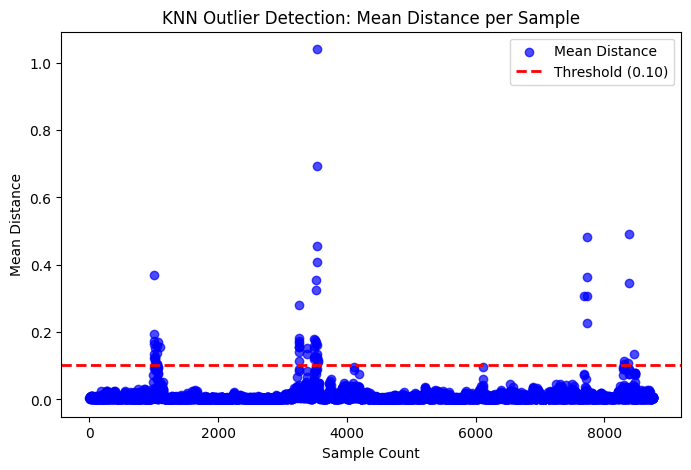

Detected 58 outliers at indices: [ 996  997  998 1000 1001 1002 1018 1020 1021 1022 1023 1043 1044 1048
 1049 1068 1096 3250 3251 3252 3253 3256 3257 3258 3259 3373 3376 3489
 3490 3492 3496 3497 3499 3512 3513 3514 3515 3517 3536 3537 3538 3539
 3540 3541 3542 3544 3545 7688 7733 7734 7735 7736 8302 8303 8376 8382
 8383 8456]
atmospheric_pressure


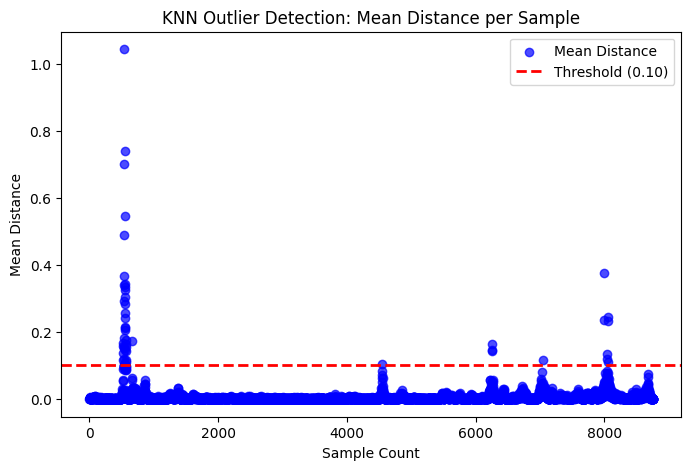

Detected 48 outliers at indices: [ 519  520  522  523  529  531  532  535  538  539  540  541  542  543
  544  545  546  547  548  549  550  552  553  554  556  557  558  559
  560  561  562  563  564  569  570  666 4541 6254 6255 6256 7042 8002
 8003 8036 8050 8051 8052 8062]
relative_humidity


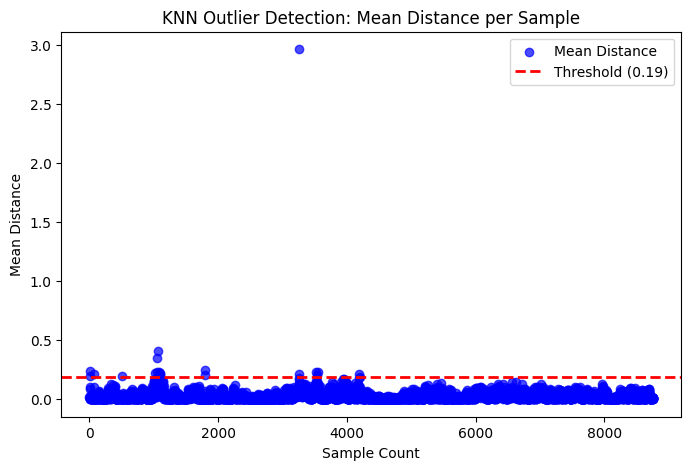

Detected 22 outliers at indices: [   4   16   67  507 1019 1045 1049 1066 1072 1080 1085 1097 1099 1103
 1796 1802 3256 3259 3525 3535 3553 4194]
Processing openmeteo_garachico for KNN outlier detection...
air_temperature


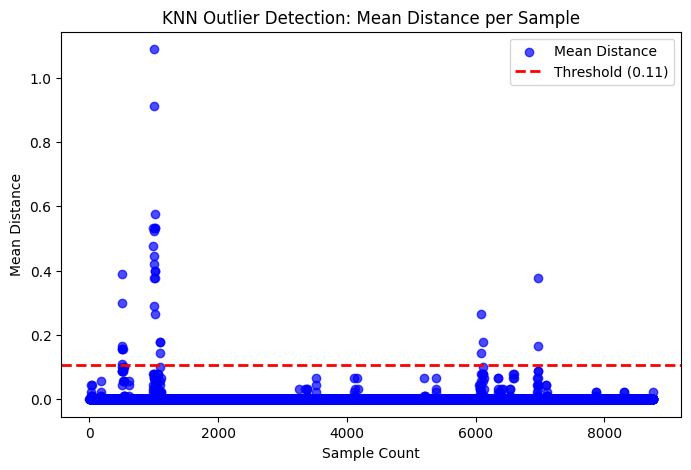

Detected 31 outliers at indices: [ 504  505  508  510  511  512  525  994  995  996  997  998  999 1000
 1001 1002 1017 1018 1019 1020 1021 1022 1023 1094 1095 1096 6083 6085
 6108 6971 6972]
atmospheric_pressure


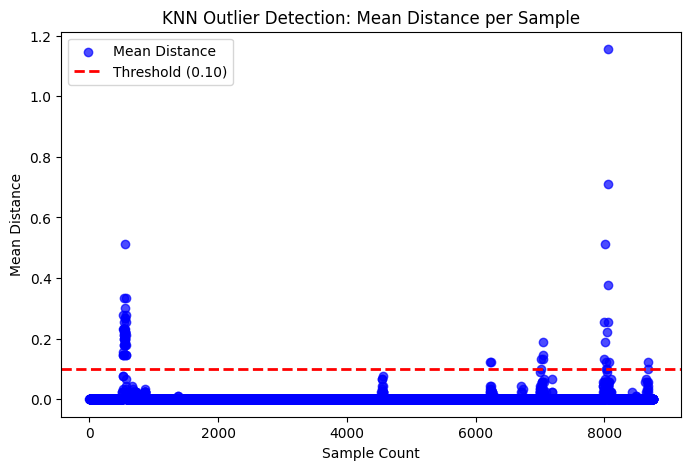

Detected 62 outliers at indices: [ 519  520  521  522  523  529  530  531  532  533  534  535  536  537
  538  539  540  541  542  543  544  545  546  547  548  549  550  551
  552  553  554  555  556  557  558  559  560  561  562  563  565  567
  568  569 6221 6246 7019 7042 7043 7044 8002 8003 8004 8005 8027 8050
 8051 8052 8053 8054 8075 8675]
relative_humidity


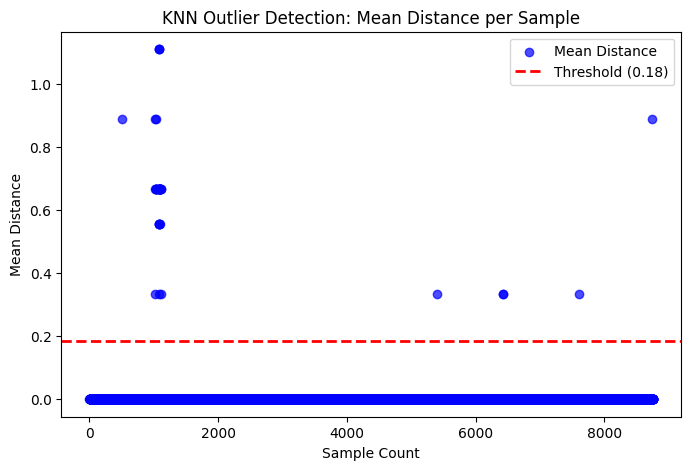

Detected 39 outliers at indices: [ 510 1018 1019 1021 1032 1033 1034 1035 1036 1037 1062 1076 1077 1078
 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1096 1097
 1101 1102 1103 1105 1113 1115 5400 6432 6433 7610 8740]


In [82]:
def knn_outlier_detection(data, k=10, threshold=4):
    """
    Detect outliers using K-Nearest Neighbors.
    
    Parameters:
    - data: 1D numpy array of values.
    - k: Number of neighbors to consider.
    - threshold: Multiplier for the mean distance to determine outliers.
    
    Returns:
    - outliers: Indices of detected outliers.
    """
    data = data.reshape(-1, 1)  # Reshape for sklearn compatibility
    
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    mean_distances = distances[:, 1:].mean(axis=1)  # Ignore self-distance (0)
    
    threshold_value = mean_distances.mean() + threshold * mean_distances.std()
    outliers = np.where(mean_distances > threshold_value)[0]
    
    # Plot distance distribution with better bin scaling
    plt.figure(figsize=(8, 5))
    plt.scatter(np.arange(len(mean_distances)), mean_distances, color='b', alpha=0.7, label='Mean Distance')
    plt.axhline(threshold_value, color='r', linestyle='dashed', linewidth=2,
                label=f'Threshold ({threshold_value:.2f})')
    #plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Sample Count')
    plt.ylabel('Mean Distance')
    plt.title('KNN Outlier Detection: Mean Distance per Sample')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers at indices: {outliers}")
    
    return outliers

for name, df in dataframes.items(): 
    print(f"Processing {name} for KNN outlier detection...")
    
    # Flag outliers initialized at 0
    flag = np.zeros(len(df), dtype=int)

    print("air_temperature")
    data = df["air_temperature"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    print("atmospheric_pressure")
    data = df["atmospheric_pressure"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1
    
    print("relative_humidity")
    data = df["relative_humidity"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    # Assign this flag array as a new column
    df["outlier_flag"] = flag

Plotting histogram for grafcan_garachico...


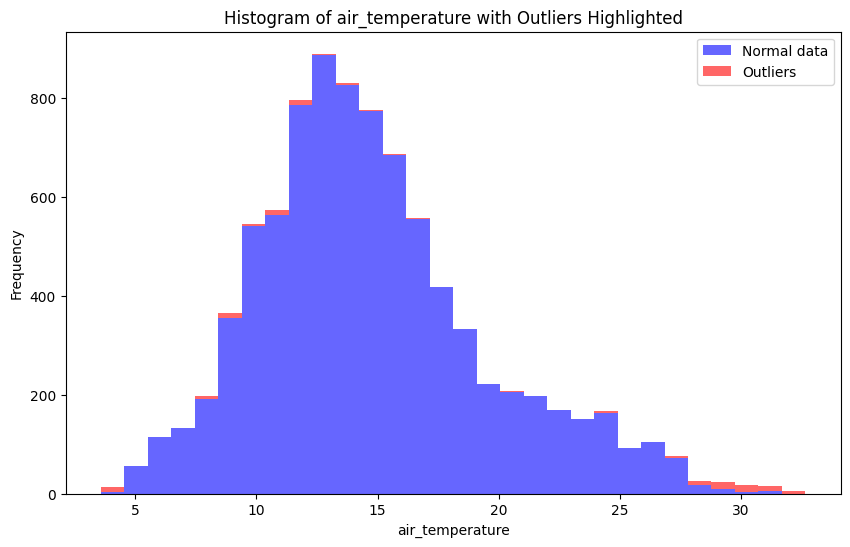

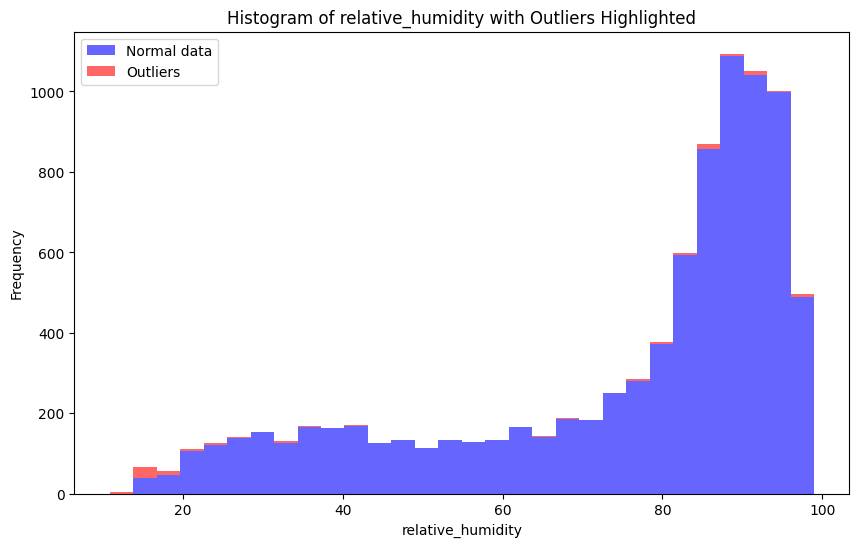

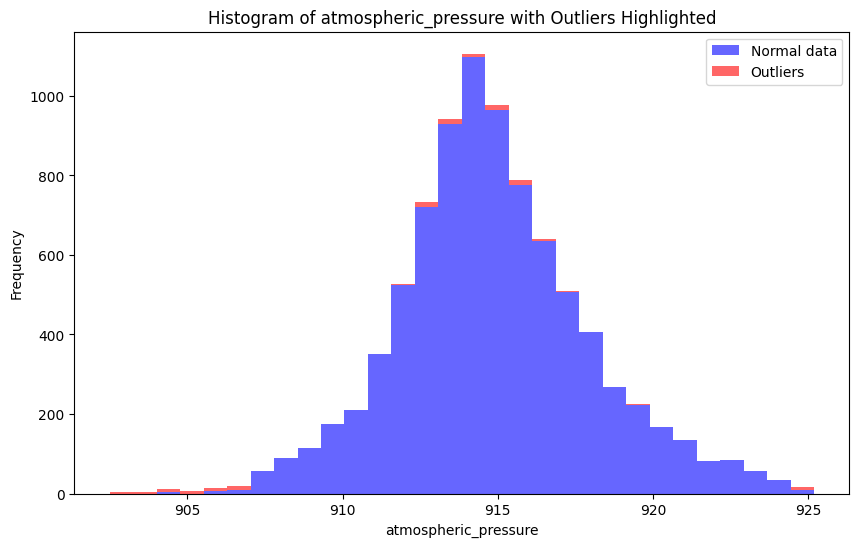

Plotting histogram for openmeteo_garachico...


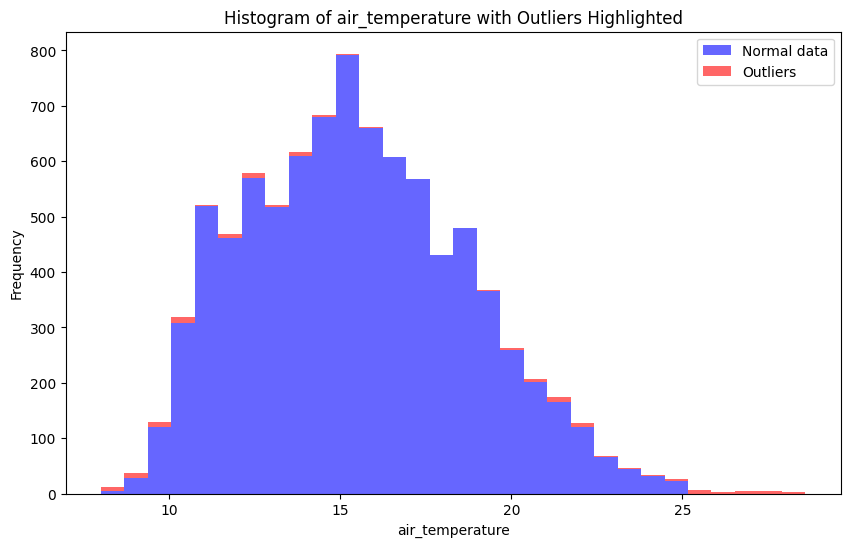

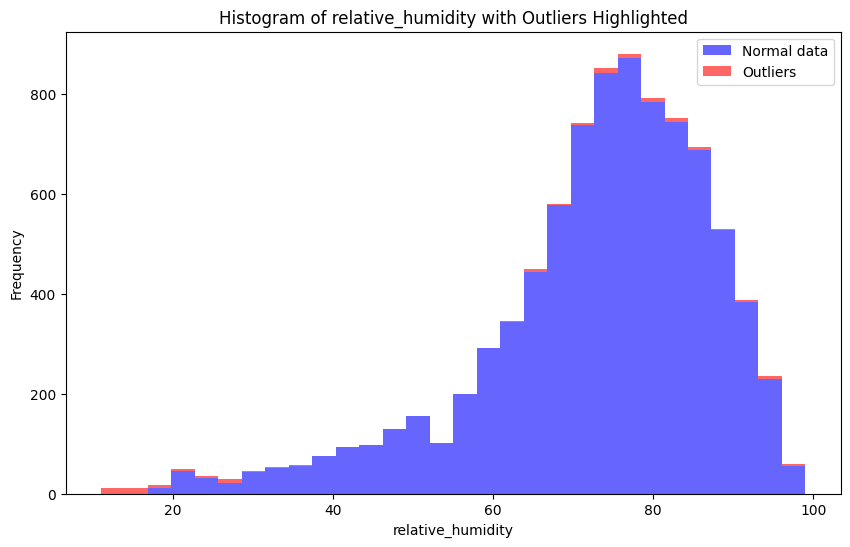

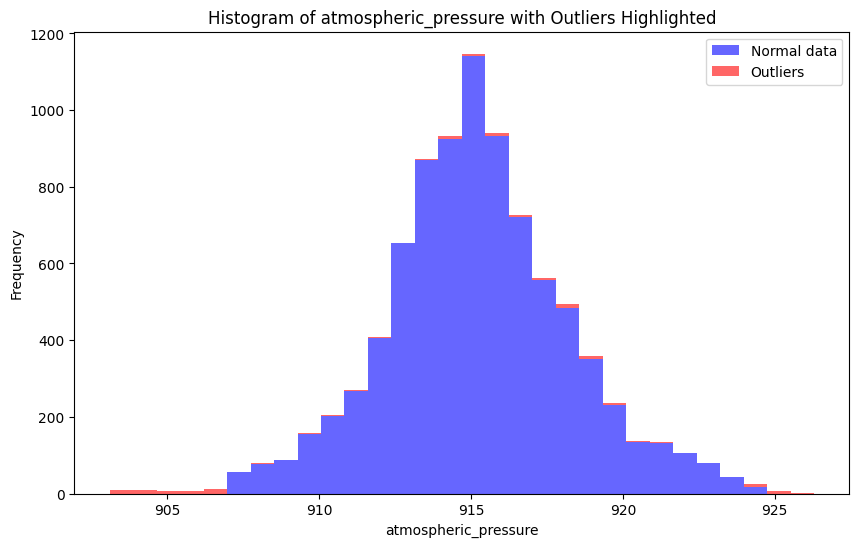

In [83]:
def plot_histogram_with_outliers(df, column, outlier_flag_column='outlier_flag', bins=30):
    """
    Plots a histogram for a specified column in the DataFrame, highlighting outliers.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: Column name (string) for which to plot the histogram.
    - outlier_flag_column: Column name (string) containing the outlier flags (default 'outlier_flag').
    - bins: Number of bins for the histogram (default 30).
    """
    plt.figure(figsize=(10, 6))
    

    # Define bin edges based on the full dataset
    bin_edges = np.histogram_bin_edges(df[column], bins=bins)
    
    # Plot normal data histogram
    plt.hist([df.loc[df[outlier_flag_column] == 0, column], df.loc[df[outlier_flag_column] == 1, column]], stacked=True, bins=bin_edges, 
             color=['blue', 'red'], alpha=0.6, label=['Normal data', 'Outliers'])
    
    plt.xlabel(column)
    plt.ylabel("Frequency")
    #plt.yscale('log')  # Log scale for y-axis
    plt.title(f"Histogram of {column} with Outliers Highlighted")
    plt.legend()
    plt.show()

# Example usage:
for df_key in dataframes.keys():
    print(f"Plotting histogram for {df_key}...")
    plot_histogram_with_outliers(dataframes[df_key], "air_temperature")
    plot_histogram_with_outliers(dataframes[df_key], "relative_humidity")
    plot_histogram_with_outliers(dataframes[df_key], "atmospheric_pressure")

## Exploración frecuencias - Fourier

In [84]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'{column}: Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Plotting frequencies for grafcan_garachico...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000013 Hz, Period: 2190.00 hours, Magnitude: 4678.6447
Frequency: 0.00000025 Hz, Period: 1095.00 hours, Magnitude: 4753.9331
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 8615.2616
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 9968.3250
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 16189.5709


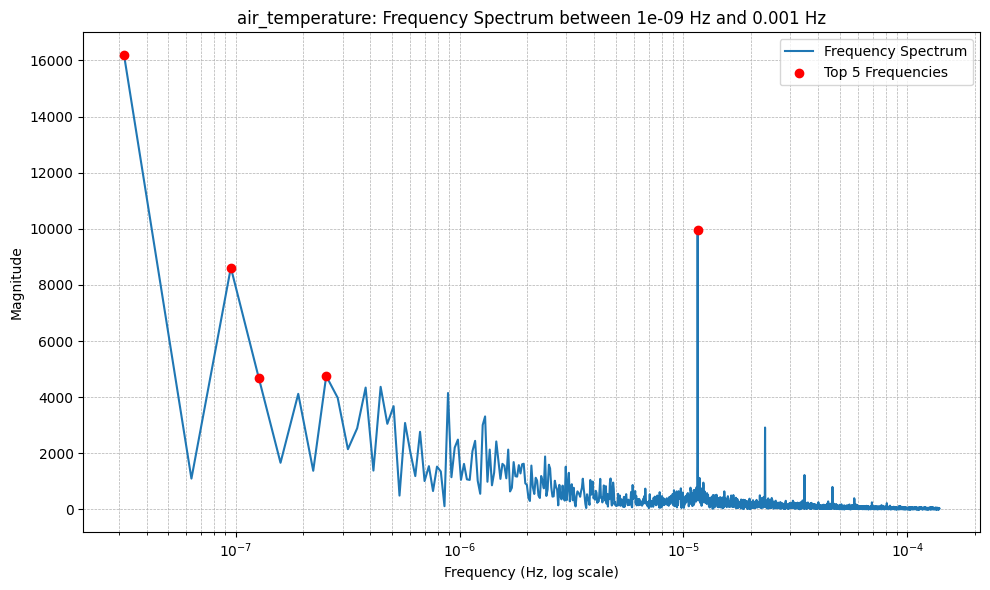

Top 5 frequencies with highest magnitude:
Frequency: 0.00000025 Hz, Period: 1095.00 hours, Magnitude: 24020.8034
Frequency: 0.00000051 Hz, Period: 547.50 hours, Magnitude: 24577.2864
Frequency: 0.00000038 Hz, Period: 730.00 hours, Magnitude: 24830.7528
Frequency: 0.00000013 Hz, Period: 2190.00 hours, Magnitude: 28865.8533
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 47281.2658


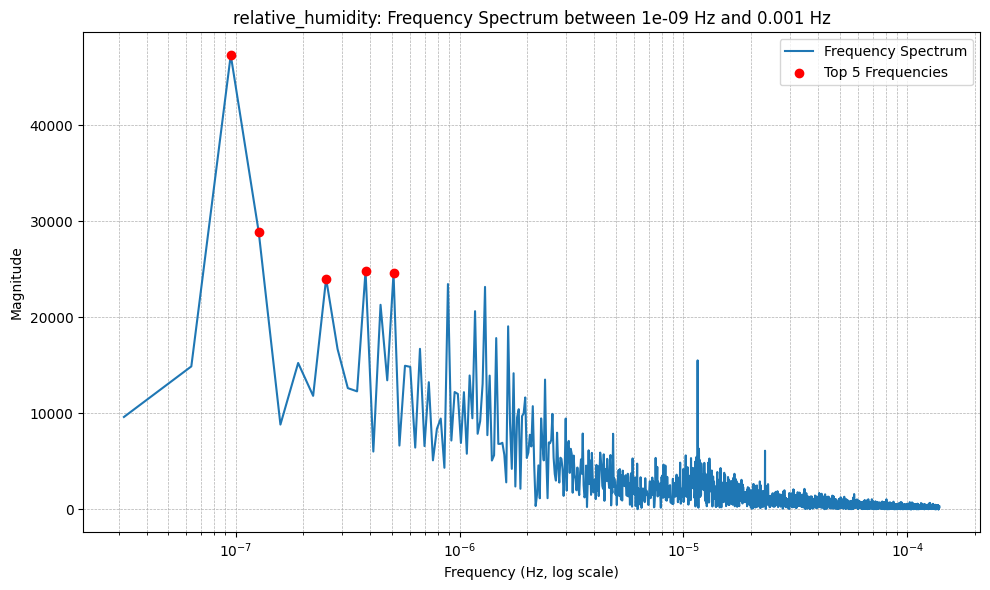

Top 5 frequencies with highest magnitude:
Frequency: 0.00000086 Hz, Period: 324.44 hours, Magnitude: 3524.0397
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 4236.1202
Frequency: 0.00000054 Hz, Period: 515.29 hours, Magnitude: 4789.8463
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 5738.1654
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 6751.4712


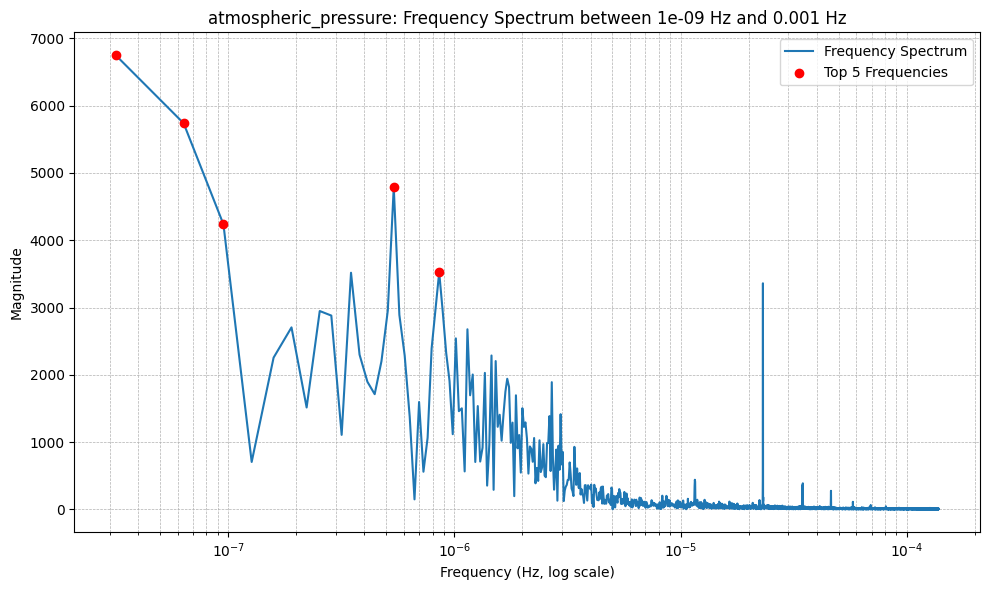

Plotting frequencies for openmeteo_garachico...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000044 Hz, Period: 625.71 hours, Magnitude: 3200.0730
Frequency: 0.00000025 Hz, Period: 1095.00 hours, Magnitude: 3208.2092
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 4933.6594
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 7021.1452
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 12351.3705


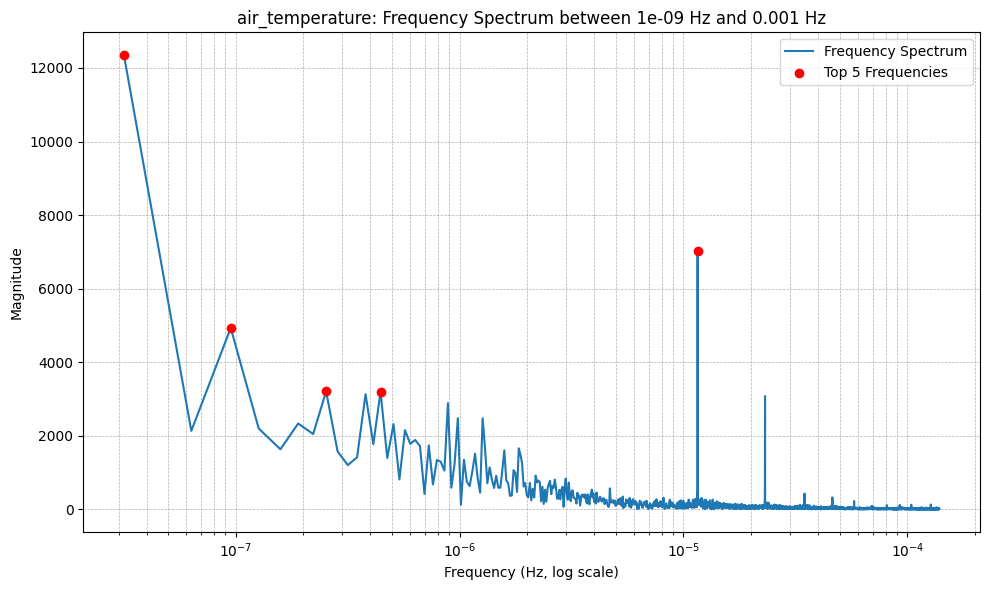

Top 5 frequencies with highest magnitude:
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 13849.5203
Frequency: 0.00000025 Hz, Period: 1095.00 hours, Magnitude: 14946.7528
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 16616.3567
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 23756.9706
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 24290.9387


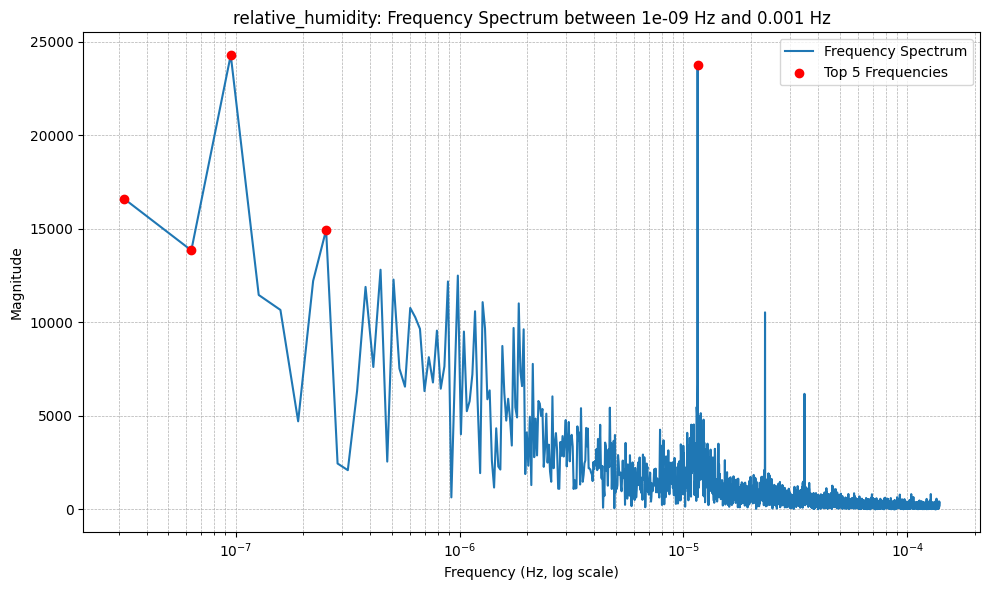

Top 5 frequencies with highest magnitude:
Frequency: 0.00000010 Hz, Period: 2920.00 hours, Magnitude: 3607.0782
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 3648.6608
Frequency: 0.00000054 Hz, Period: 515.29 hours, Magnitude: 4791.5429
Frequency: 0.00000006 Hz, Period: 4380.00 hours, Magnitude: 5308.9749
Frequency: 0.00000003 Hz, Period: 8760.00 hours, Magnitude: 5350.3577


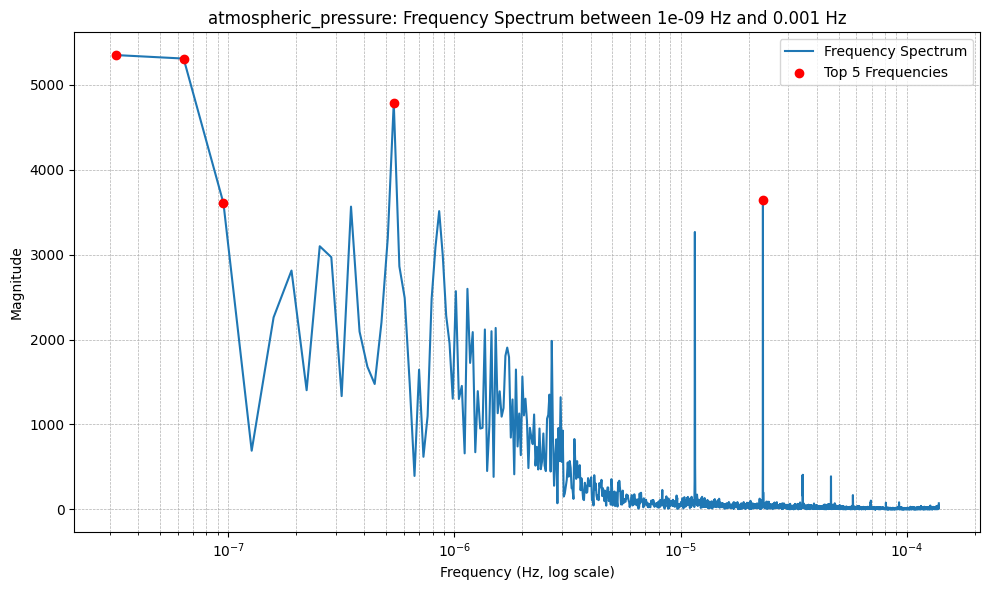

In [85]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

for name, df in dataframes.items():
  print(f"Plotting frequencies for {name}...")
  plot_frequencies(df, "air_temperature", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "relative_humidity", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Adición datos temporales

In [86]:
def add_time_features(df): 
    # Extract hour and minute to get a more continuous representation of time within a day
    df.index.name = "time"
    df.reset_index(inplace=True)

    df['time'] = pd.to_datetime(df['time'])
    hours = df['time'].dt.hour
    minutes  = df['time'].dt.minute
    hour_fraction = hours + minutes / 60.0

    # Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
    df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
    df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    day_of_week = df['time'].dt.weekday
    week_fraction = day_of_week + hour_fraction / 24.0  

    df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
    df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

    # For annual features: extract the day of the year (1-366)
    day_of_year = df['time'].dt.dayofyear

    # Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
    year_fraction = (day_of_year - 1) + hour_fraction / 24.0

    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Apply the leap year function and store the result
    df['leap_year'] = df['time'].dt.year.apply(is_leap_year)

    df['sin_year'] = np.sin(2 * np.pi * year_fraction / (365 + df['leap_year']))
    df['cos_year'] = np.cos(2 * np.pi * year_fraction / (365 + df['leap_year']))

    # Drop the aux leap year variable
    df.drop(columns="leap_year", inplace=True)
                            
    # Remove original time variable
    #df.drop(columns="time", inplace=True)
    
for df in dataframes.values():
    add_time_features(df)


Plotting correlations for grafcan_garachico...


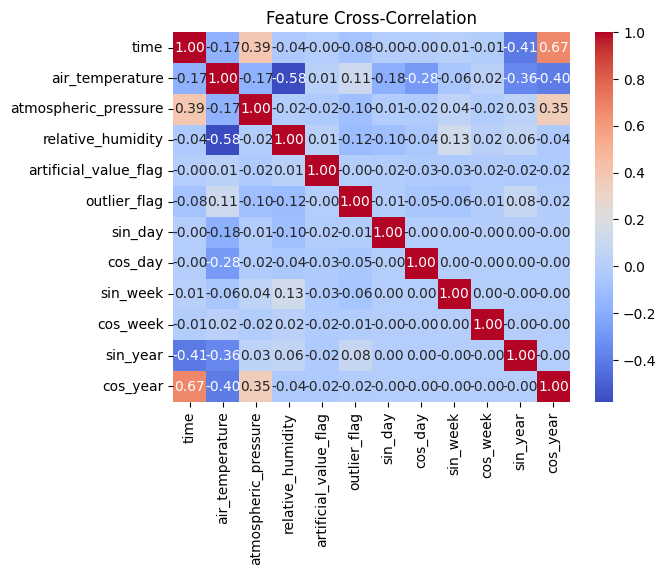

Plotting correlations for openmeteo_garachico...


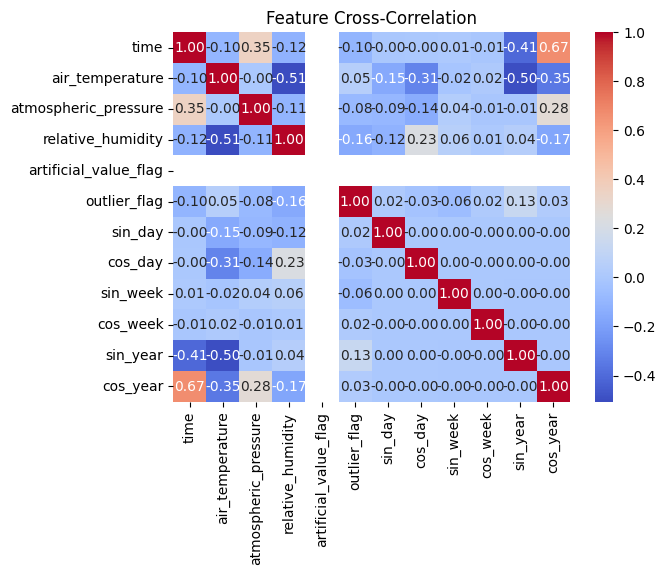

In [87]:
for name, df in dataframes.items():
  print (f"Plotting correlations for {name}...")
  
  correlation_matrix = df.corr()

  # Heatmap for visualization
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Feature Cross-Correlation")
  plt.show()


In [88]:
for df in dataframes.values():
  df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Escritura fichero 

In [89]:
for name, df in dataframes.items():
  df.to_csv("processed_data/" + name + "_features.csv", index=False)